In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from torchvision.io import read_image
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import os
import time
import timm

# === Configurations ===
MODEL_NAME = "swinv2_small_window16_256"
DATA_DIR = "/kaggle/input/aptos2019-blindness-detection/train_images"
CSV_PATH = "/kaggle/input/aptos2019-blindness-detection/train.csv"
MODEL_SAVE = "/kaggle/working/swinv2_metrics.csv"
LEARNING_RATE = 1e-4
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TRAIN_SPLIT = 0.8
NUM_WORKERS = 2
USE_AMP = True
EPOCHS = 50

# === Dataset Class ===
class RetinopathyDataset(Dataset):
    def __init__(self, image_dir, csv_file, transforms=None):
        self.transforms = transforms
        self.image_dir = image_dir
        self.data = pd.read_csv(csv_file)

        # Filter only rows with existing images
        existing_images = set(os.listdir(image_dir))
        self.data = self.data[self.data['id_code'].apply(lambda x: f"{x}.png" in existing_images)].reset_index(drop=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.data.loc[idx, 'id_code'] + '.png')
        tensor_image = read_image(img_name)
        label = torch.tensor(self.data.loc[idx, 'diagnosis'], dtype=torch.long)
        if self.transforms is not None:
            tensor_image = self.transforms(tensor_image)
        return tensor_image, label

# === Transforms ===
train_transforms = T.Compose([
    T.Resize((256, 256)),
    T.ConvertImageDtype(torch.float32),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# === Data Loading ===
full_dataset = RetinopathyDataset(DATA_DIR, CSV_PATH, transforms=train_transforms)
train_size = int(TRAIN_SPLIT * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# === Device and AMP ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = torch.cuda.amp.GradScaler() if USE_AMP else None

# === Model (image-only for training) ===
model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=5)
model = model.to(device)

# === Class Weights ===
train_df = pd.read_csv(CSV_PATH)
class_labels = train_df['diagnosis'].values
unique_classes = np.unique(class_labels)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=class_labels)
weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# === Loss & Optimizer ===
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# === Training & Validation Functions ===
def train_step(model, train_loader, criterion, device, optimizer, scaler=None):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, targets in tqdm(train_loader, desc="Training", leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        if scaler:
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        correct += outputs.argmax(1).eq(targets).sum().item()
        total += inputs.size(0)
    return {"loss": total_loss / total, "accuracy": 100.0 * correct / total}

def val_step(model, val_loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc="Validation", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            correct += outputs.argmax(1).eq(targets).sum().item()
            total += inputs.size(0)
    return {"loss": total_loss / total, "accuracy": 100.0 * correct / total}

# === Training Loop ===
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []
start_time = time.time()

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    train_metrics = train_step(model, train_loader, criterion, device, optimizer, scaler)
    val_metrics = val_step(model, val_loader, criterion, device)
    train_loss.append(train_metrics["loss"])
    train_accuracy.append(train_metrics["accuracy"])
    val_loss.append(val_metrics["loss"])
    val_accuracy.append(val_metrics["accuracy"])
    print(f"Train Acc: {train_metrics['accuracy']:.2f}% | Val Acc: {val_metrics['accuracy']:.2f}%")
    torch.save(model.state_dict(), f"/kaggle/working/{MODEL_NAME}_epoch{epoch+1}.pt")

# === Save Metrics to CSV ===
metrics_df = pd.DataFrame({
    "epoch": list(range(1, EPOCHS + 1)),
    "train_loss": train_loss,
    "train_accuracy": train_accuracy,
    "val_loss": val_loss,
    "val_accuracy": val_accuracy
})
metrics_df.to_csv(MODEL_SAVE, index=False)
print("✅ Training complete and metrics saved.")

/tmp/ipykernel_23/1870237637.py:67: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if USE_AMP else None


model.safetensors:   0%|          | 0.00/204M [00:00<?, ?B/s]

Epoch 1/50


Training:   0%|          | 0/92 [00:00<?, ?it/s]/tmp/ipykernel_23/1870237637.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Acc: 63.47% | Val Acc: 63.03%
Epoch 2/50


Train Acc: 76.78% | Val Acc: 77.22%
Epoch 3/50


Train Acc: 81.46% | Val Acc: 72.85%
Epoch 4/50


Train Acc: 85.52% | Val Acc: 76.94%
Epoch 5/50


Train Acc: 89.18% | Val Acc: 78.85%
Epoch 6/50


Train Acc: 89.79% | Val Acc: 81.45%
Epoch 7/50


Train Acc: 92.22% | Val Acc: 83.63%
Epoch 8/50


Train Acc: 94.43% | Val Acc: 81.04%
Epoch 9/50


Train Acc: 96.55% | Val Acc: 81.31%
Epoch 10/50


Train Acc: 96.01% | Val Acc: 80.35%
Epoch 11/50


Train Acc: 97.68% | Val Acc: 81.58%
Epoch 12/50


Train Acc: 96.82% | Val Acc: 83.36%
Epoch 13/50


Train Acc: 97.27% | Val Acc: 82.95%
Epoch 14/50


Train Acc: 98.12% | Val Acc: 81.86%
Epoch 15/50


Train Acc: 96.62% | Val Acc: 83.90%
Epoch 16/50


Train Acc: 98.22% | Val Acc: 83.63%
Epoch 17/50


Train Acc: 98.19% | Val Acc: 84.99%
Epoch 18/50


Train Acc: 97.78% | Val Acc: 82.54%
Epoch 19/50


Train Acc: 97.34% | Val Acc: 80.63%
Epoch 20/50


Train Acc: 94.50% | Val Acc: 81.99%
Epoch 21/50


Train Acc: 96.01% | Val Acc: 79.40%
Epoch 22/50


Train Acc: 96.65% | Val Acc: 83.08%
Epoch 23/50


Train Acc: 98.12% | Val Acc: 83.36%
Epoch 24/50


Train Acc: 98.81% | Val Acc: 83.08%
Epoch 25/50


Train Acc: 98.81% | Val Acc: 83.77%
Epoch 26/50


Train Acc: 98.84% | Val Acc: 82.81%
Epoch 27/50


Train Acc: 98.40% | Val Acc: 84.86%
Epoch 28/50


Train Acc: 95.25% | Val Acc: 82.54%
Epoch 29/50


Train Acc: 98.05% | Val Acc: 83.77%
Epoch 30/50


Train Acc: 98.67% | Val Acc: 84.45%
Epoch 31/50


Train Acc: 98.84% | Val Acc: 84.45%
Epoch 32/50


Train Acc: 98.87% | Val Acc: 83.77%
Epoch 33/50


Train Acc: 98.98% | Val Acc: 84.45%
Epoch 34/50


Train Acc: 98.94% | Val Acc: 84.99%
Epoch 35/50


Train Acc: 98.98% | Val Acc: 84.04%
Epoch 36/50


Train Acc: 98.57% | Val Acc: 83.08%
Epoch 37/50


Train Acc: 98.81% | Val Acc: 83.36%
Epoch 38/50


Train Acc: 98.98% | Val Acc: 84.58%
Epoch 39/50


Train Acc: 98.60% | Val Acc: 81.58%
Epoch 40/50


Train Acc: 95.32% | Val Acc: 80.08%
Epoch 41/50


Train Acc: 96.52% | Val Acc: 83.90%
Epoch 42/50


Train Acc: 98.36% | Val Acc: 82.40%
Epoch 43/50


Train Acc: 97.41% | Val Acc: 82.26%
Epoch 44/50


Train Acc: 97.92% | Val Acc: 83.77%
Epoch 45/50


Train Acc: 97.81% | Val Acc: 84.17%
Epoch 46/50


Train Acc: 98.09% | Val Acc: 81.99%
Epoch 47/50


Train Acc: 97.88% | Val Acc: 84.99%
Epoch 48/50


Train Acc: 98.60% | Val Acc: 83.90%
Epoch 49/50


Train Acc: 98.19% | Val Acc: 83.22%
Epoch 50/50


Train Acc: 98.74% | Val Acc: 84.58%
✅ Training complete and metrics saved.


In [3]:
# Save the final model state_dict
FINAL_MODEL_PATH = "/kaggle/working/model.pt"
torch.save(model.state_dict(), FINAL_MODEL_PATH)
print("✅ Final model saved at:", FINAL_MODEL_PATH)

✅ Final model saved at: /kaggle/working/Praveen.pt


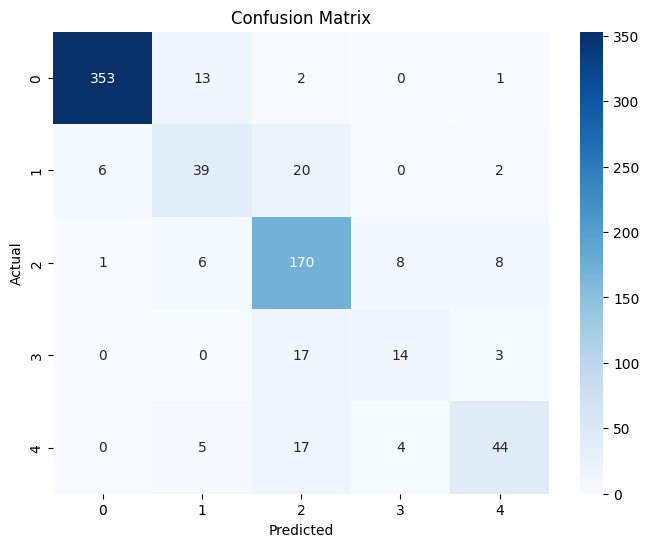

Classification Report:

              precision    recall  f1-score   support

           0     0.9806    0.9566    0.9684       369
           1     0.6190    0.5821    0.6000        67
           2     0.7522    0.8808    0.8115       193
           3     0.5385    0.4118    0.4667        34
           4     0.7586    0.6286    0.6875        70

    accuracy                         0.8458       733
   macro avg     0.7298    0.6920    0.7068       733
weighted avg     0.8457    0.8458    0.8433       733



In [4]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === Evaluation Function ===
def evaluate_model(model, val_loader, device):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc="Evaluating", leave=False):
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(targets.numpy())
    
    # Confusion Matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(5), yticklabels=range(5))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    # Classification Report
    report = classification_report(all_targets, all_preds, digits=4)
    print("Classification Report:\n")
    print(report)

# === Load Best Model if needed ===
# model.load_state_dict(torch.load("/kaggle/working/best_model.pt"))  # Uncomment if evaluating a specific saved model

# === Run Evaluation ===
evaluate_model(model, val_loader, device)


In [2]:
from sklearn.metrics import cohen_kappa_score

# Reconstruct true and predicted labels from the confusion matrix
true_labels = []
pred_labels = []

conf_matrix = [
    [353, 3, 10, 1, 2],
    [11, 39, 14, 2, 1],
    [1, 5, 170, 11, 6],
    [1, 1, 6, 14, 12],
    [1, 0, 7, 18, 44],
]

for true_class, row in enumerate(conf_matrix):
    for pred_class, count in enumerate(row):
        true_labels.extend([true_class] * count)
        pred_labels.extend([pred_class] * count)

# Compute Cohen's Kappa Score
kappa = cohen_kappa_score(true_labels, pred_labels)
print("Cohen's Kappa Score:", kappa)

Cohen's Kappa Score: 0.7650807606676404


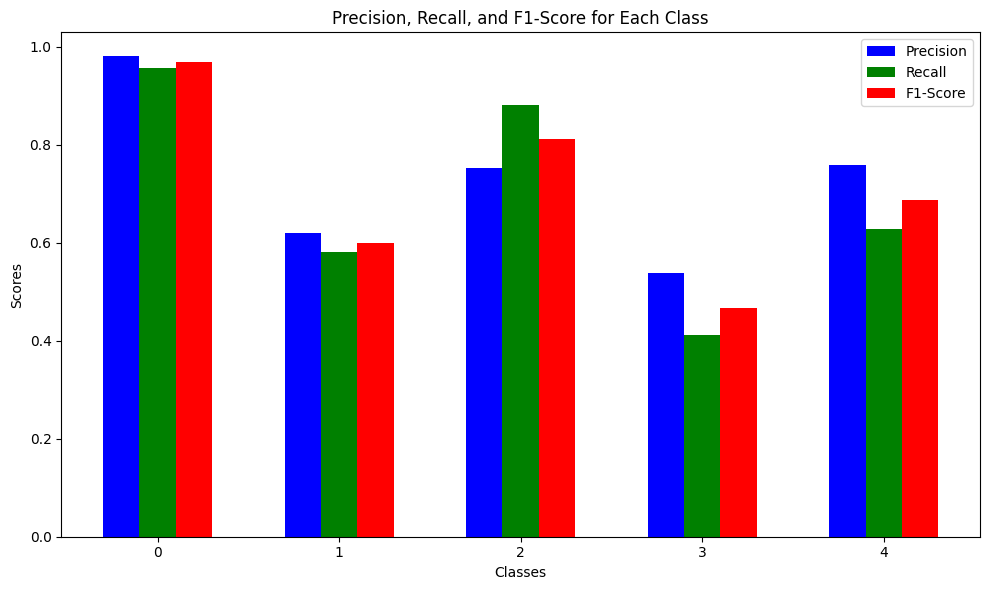

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the classification report
labels = ['0', '1', '2', '3', '4']
precision = [0.9806, 0.6190, 0.7522, 0.5385, 0.7586]
recall = [0.9566, 0.5821, 0.8808, 0.4118, 0.6286]
f1_score = [0.9684, 0.6000, 0.8115, 0.4667, 0.6875]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Bar width
bar_width = 0.2

# Set x positions for each bar group
x = np.arange(len(labels))

# Create bars for precision, recall, and f1-score
ax.bar(x - bar_width, precision, bar_width, label='Precision', color='b')
ax.bar(x, recall, bar_width, label='Recall', color='g')
ax.bar(x + bar_width, f1_score, bar_width, label='F1-Score', color='r')

# Add labels, title, and customize ticks
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score for Each Class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Show plot
plt.tight_layout()
plt.show()
